In [1]:
import numpy as np
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Train/Test 합치기
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test], ignore_index=True)
print(f"Combined DataFrame shape: {df.shape}")
print("Train과 Test 데이터 병합 완료")

df

Train data shape: (750000, 10)
Test data shape: (250000, 9)
Combined DataFrame shape: (1000000, 11)
Train과 Test 데이터 병합 완료


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,is_train
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,1
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,1
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,1
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,1
4,4,35,58,43,Red,Paddy,37,2,16,DAP,1
...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,26,66,30,Red,Sugarcane,14,7,18,NaN,0
999996,999996,33,62,55,Red,Pulses,28,14,7,NaN,0
999997,999997,36,53,64,Black,Paddy,28,11,27,NaN,0
999998,999998,36,67,26,Clayey,Paddy,33,0,10,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   id               1000000 non-null  int64 
 1   Temparature      1000000 non-null  int64 
 2   Humidity         1000000 non-null  int64 
 3   Moisture         1000000 non-null  int64 
 4   Soil Type        1000000 non-null  object
 5   Crop Type        1000000 non-null  object
 6   Nitrogen         1000000 non-null  int64 
 7   Potassium        1000000 non-null  int64 
 8   Phosphorous      1000000 non-null  int64 
 9   Fertilizer Name  750000 non-null   object
 10  is_train         1000000 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 83.9+ MB


In [3]:
print("Soil Type 종류:", df['Soil Type'].unique())
print("Crop Type 종류:", df['Crop Type'].unique())

Soil Type 종류: ['Clayey' 'Sandy' 'Red' 'Loamy' 'Black']
Crop Type 종류: ['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']


In [4]:
print("Soil Type 분포:\n", df['Soil Type'].value_counts())
print("Crop Type 분포:\n", df['Crop Type'].value_counts())

Soil Type 분포:
 Soil Type
Sandy     209033
Black     201103
Clayey    198174
Red       197461
Loamy     194229
Name: count, dtype: int64
Crop Type 분포:
 Crop Type
Paddy          114086
Pulses         104401
Cotton          92262
Tobacco         90728
Wheat           88722
Millets         87180
Barley          86761
Sugarcane       85836
Oil seeds       85711
Maize           83472
Ground Nuts     80841
Name: count, dtype: int64


In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# ✅ 범주형 변수 원핫 인코딩
df = pd.get_dummies(df, columns=['Soil Type', 'Crop Type'])

# train 데이터 분리
train = df[df['is_train'] == 1].dropna(subset=['Fertilizer Name'])

# Fertilizer Name 인코딩 (타겟 변수만 LabelEncoder 유지)
target_le = LabelEncoder()
y = target_le.fit_transform(train['Fertilizer Name'])


✅ 왜 범주형은 "train + test 전체"에서 인코딩해야 할까?
예시 상황:
train에는 Soil Type = "Sandy"와 "Clay"만 있는데

test에는 "Peaty"도 등장함

→ 만약 train 기준으로만 LabelEncoder().fit()하면 "Peaty"는 unseen category가 돼서 에러남

그래서 Soil Type, Crop Type 같이 **입력 피처(feature)**는 반드시 전체 데이터 기준으로 인코딩해야 함

✅ 반대로 타겟 변수는 왜 train만 써야 할까?
Fertilizer Name은 예측 대상(test에 결측치 있음)이므로 train만으로 .fit()하고,
나중에 예측 후 .inverse_transform()으로 다시 문자열로 복원할 수 있어야 하기 때문


In [6]:
df

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Fertilizer Name,is_train,Soil Type_Black,...,Crop Type_Cotton,Crop Type_Ground Nuts,Crop Type_Maize,Crop Type_Millets,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat
0,0,37,70,36,36,4,5,28-28,1,False,...,False,False,False,False,False,False,False,True,False,False
1,1,27,69,65,30,6,18,28-28,1,False,...,False,False,False,True,False,False,False,False,False,False
2,2,29,63,32,24,12,16,17-17-17,1,False,...,False,False,False,True,False,False,False,False,False,False
3,3,35,62,54,39,12,4,10-26-26,1,False,...,False,False,False,False,False,False,False,False,False,False
4,4,35,58,43,37,2,16,DAP,1,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,26,66,30,14,7,18,NaN,0,False,...,False,False,False,False,False,False,False,True,False,False
999996,999996,33,62,55,28,14,7,NaN,0,False,...,False,False,False,False,False,False,True,False,False,False
999997,999997,36,53,64,28,11,27,NaN,0,True,...,False,False,False,False,False,True,False,False,False,False
999998,999998,36,67,26,33,0,10,NaN,0,False,...,False,False,False,False,False,True,False,False,False,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   id                     1000000 non-null  int64 
 1   Temparature            1000000 non-null  int64 
 2   Humidity               1000000 non-null  int64 
 3   Moisture               1000000 non-null  int64 
 4   Nitrogen               1000000 non-null  int64 
 5   Potassium              1000000 non-null  int64 
 6   Phosphorous            1000000 non-null  int64 
 7   Fertilizer Name        750000 non-null   object
 8   is_train               1000000 non-null  int64 
 9   Soil Type_Black        1000000 non-null  bool  
 10  Soil Type_Clayey       1000000 non-null  bool  
 11  Soil Type_Loamy        1000000 non-null  bool  
 12  Soil Type_Red          1000000 non-null  bool  
 13  Soil Type_Sandy        1000000 non-null  bool  
 14  Crop Type_Barley       1000000 non-

In [8]:
# 불필요한 컬럼 제거
X = train.drop(columns=['id', 'Fertilizer Name', 'is_train'])

In [9]:
# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 모델 학습
model = XGBClassifier(
    tree_method="hist",
    enable_categorical=True,
    eval_metric="mlogloss",
    random_state=42
)

model.fit(X_train, y_train)  # 그냥 학습만 먼저 진행

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
def map3_score_single(actual, predicted_flat, n_classes=7):
    n_samples = actual.shape[0]
    pred = predicted_flat.reshape(n_samples, n_classes)
    top3 = np.argsort(-pred, axis=1)[:, :3]
    matches = (top3 == actual[:, None])
    weights = np.array([1.0, 0.5, 1.0/3], dtype=np.float32)
    scores = np.sum(matches * weights[None, :], axis=1)
    return np.mean(scores)

In [11]:
# 1. 검증 데이터에 대한 예측 확률 생성
val_probs = model.predict_proba(X_val)

# 2. MAP@3 점수 계산
val_map3 = map3_score_single(y_val, val_probs, n_classes=len(target_le.classes_))
print(f"📊 Validation MAP@3 Score: {val_map3:.5f}")

# 3. OOF 결과 npy 저장 (힐클라이밍용)
np.save("xgb_val_probs.npy", val_probs)
np.save("xgb_val_labels.npy", y_val)

print("✅ 검증 OOF 결과 .npy 저장 완료!")

📊 Validation MAP@3 Score: 0.32999
✅ 검증 OOF 결과 .npy 저장 완료!


In [3]:
import os
import sys
import sys
print(sys.prefix)

c:\Users\user\anaconda3


In [12]:
import numpy as np
import pandas as pd

# === TEST 예측 ===
test = df[df['is_train'] == 0].copy()
X_test = test.drop(columns=['id', 'Fertilizer Name', 'is_train'])

# 클래스별 확률 예측
probs = model.predict_proba(X_test)  # shape: (n_samples, n_classes)

# MAP@3용 top-3 인덱스 추출
top3_indices = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # 높은 순 정렬

# 안전하게 클래스 인덱스 → 라벨로 변환
if np.max(top3_indices) >= len(target_le.classes_):
    print(f"WARNING: Found index {np.max(top3_indices)} but only have {len(target_le.classes_)} classes")
    top3_indices = np.clip(top3_indices, 0, len(target_le.classes_) - 1)

top3_labels = target_le.inverse_transform(top3_indices.flatten()).reshape(-1, 3)

# 제출용 문자열 조합
top3_strings = [' '.join(row) for row in top3_labels]

# === SUBMISSION 생성 ===
submission = pd.DataFrame({
    'ID': test['id'],
    'Fertilizer Name': top3_strings
})
submission.to_csv('submission.csv', index=False)

print("✅ submission.csv 저장 완료!")

✅ submission.csv 저장 완료!


## baseline model(xgboost) = 0.33051

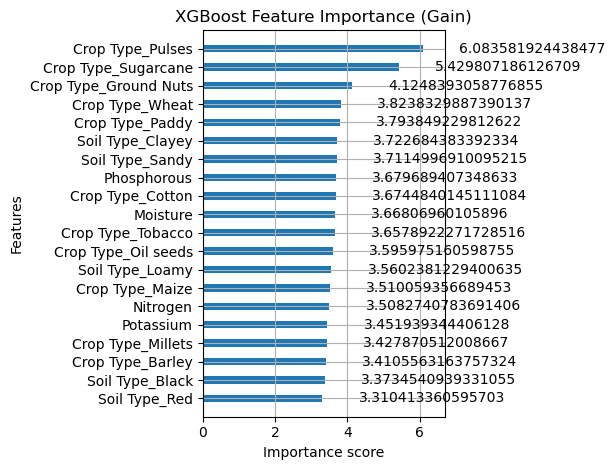

In [13]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 중요도 추출 (기본은 'weight', 'gain', 'cover' 중 선택 가능
# gain"변수가 모델 성능을 얼마나 개선했는가"를 보여주는 가장 직관적인 기준
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.4)
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()